In [1]:
## FMR1 SD MUA analysis 1.00

#%% file import pre procesing
import pandas as pd
import numpy as np


import io 
import requests 
import os
import glob
#plots
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from matplotlib.ticker import MaxNLocator

import tdt

from array import *

# File extraction
## From master table to form file list to loop over

In [3]:
# load in file list csv
#t1 = pd.read_excel('F:/Fmr1 SD Tanks/fmr1_sd_tank_info.xlsx')
t1 = pd.read_excel('/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/fmr1_sd_tank_info.xlsx')
t1

,Subject,Genotype,Penetration,Tank,Block,Condition,Comments
0,11,fmr1 WT,AC-IC,BA190305A,1,RLF,NaN
1,11,fmr1 WT,AC-IC,BA190305A,2,eFRA,NaN
2,11,fmr1 WT,AC-IC,BA190305A,3,Spont,NaN
3,11,fmr1 WT,AC-MGB,BA190305B,1,RLF,NaN
4,11,fmr1 WT,AC-MGB,BA190305B,2,Spont,NaN
...,...,...,...,...,...,...,...
184,16,fmr1 KO,AC-LA,BA190328I,5,RLF,NaN
185,16,fmr1 KO,MGB-LA,BA190326J,1,RLF,NaN
186,16,fmr1 KO,MGB-LA,BA190326J,2,Spont,NaN
187,16,fmr1 KO,MGB-LA,BA190326J,3,eFRA,NaN


In [4]:
# specify region of interest
region = '-IC'
stim_type = 'RLF'
#region_t1 = t1.loc[t1['Penetration'] == region]
#region_ind = t1['Penetration'].str.contains(region)
region_t1 = t1.loc[t1['Penetration'].str.contains(region,regex=False)]
#region_t1 = t1(index)
region_stim_t1 = region_t1.loc[t1['Condition'].str.contains(stim_type,regex=False)]

region_stim_t1

,Subject,Genotype,Penetration,Tank,Block,Condition,Comments
0,11,fmr1 WT,AC-IC,BA190305A,1,RLF,NaN
18,11,fmr1 WT,AC-IC,BA190305G,1,RLF,NaN
21,11,fmr1 WT,AC-IC,BA190305H,1,RLF,NaN
33,12,fmr1 KO,AC-IC,BA190306A,1,RLF,NaN
51,12,fmr1 KO,AC-IC,BA190306H,1,RLF,NaN
53,12,fmr1 KO,AC-IC,BA190306I,1,RLF,NaN
64,13,fmr1 KO,AC-IC,BA190312A,1,RLF,Swelling
83,13,fmr1 KO,AC-IC,BA190312H,1,RLF,NaN
85,13,fmr1 KO,AC-IC,BA190312I,1,RLF,NaN
94,14,fmr1 WT,AC-IC,BA190313A,1,RLF,NaN


In [5]:
# just need last half of files now
files_needed = ['BA190313I','BA190326A','BA190326I','BA190328A','BA190328H']
region_stim_t1 = region_stim_t1.loc[region_stim_t1['Tank'].isin(files_needed)]
region_stim_t1

,Subject,Genotype,Penetration,Tank,Block,Condition,Comments
115,14,fmr1 WT,AC-IC,BA190313I,1,RLF,NaN
125,15,fmr1 WT,AC-IC,BA190326A,1,RLF,NaN
145,15,fmr1 WT,AC-IC,BA190326I,1,RLF,NaN
157,16,fmr1 KO,AC-IC,BA190328A,1,RLF,NaN
177,16,fmr1 KO,AC-IC,BA190328H,1,RLF,NaN


In [8]:
# generate file list from region and condition chosen
# can alter for different local systems
tank_dir = '/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks'
WT_ls = [11,14,15]
KO_ls = [12,13,16]

sub_ls = pd.unique(region_stim_t1['Subject'])

file_ls = [] # placeholder where generated file paths will be added to 

for i in sub_ls: 
    sub_rows = region_stim_t1.loc[region_stim_t1['Subject'] == i] # get all recording info for given subject
    
    if i in WT_ls:
        file_path = tank_dir + '/WT'
    if i in KO_ls:
        file_path = tank_dir + '/KO'
        
    for index, row in sub_rows.iterrows():
        current_tank = row['Tank']
        current_block = row['Block']
        current_block = str(current_block)
        current_block = 'Block-'+current_block
        
        parsed_path = os.path.join(file_path,current_tank,current_block) # stitch together path
        file_ls.append(parsed_path) # add path to list


# Get stim params

In [9]:
# load in parameters from an exaple file
REF_EPOC = 'Freq'
Lev_EPOC = 'Levl'
SNIP_STORE = 'Snip'
SORTID = 'TankSort'
CHANNEL = 20
SORTCODE = 0 # set to 0 to use all sorts
TRANGE = [-0.1, 0.2]
BLOCK_PATH = file_ls[1]

data = tdt.read_block(BLOCK_PATH, evtype=['epocs', 'snips', 'scalars'],
            sortname=SORTID, channel=CHANNEL, nodata=1)

freq_ls = np.unique(data.epocs.Freq.data) # get list of all freqs used
freq_ls = 0
#index_khz_ls = np.where(freq_ls != -1) # need to drop -1
#freq_ls = freq_ls[index_khz_ls]


dB_ls = np.unique(data.epocs.Levl.data) # get list of all dBs used
index_dB_ls = np.where(dB_ls != -100) # need to drop -100
dB_ls = dB_ls[index_dB_ls]


read from t=0s to t=576.06s


AttributeError: 'StructType' object has no attribute 'Freq'

# Extract relevant data from each recording
# Plot example plots from each recording to check 

read from t=0s to t=969.5s


C:\Users\admin\AppData\Local\Temp\ipykernel_27244\228764651.py:47: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "k." (-> marker='.'). The keyword argument will take precedence.
  ax1.plot(all_x, all_y, 'k.', markersize=3, marker = '|')


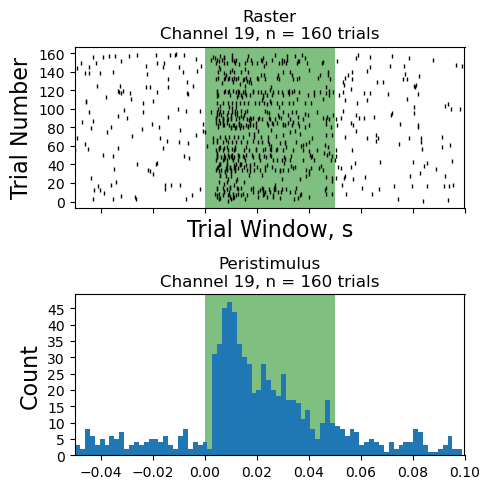

In [13]:
REF_EPOC = 'Freq'
Lev_EPOC = 'Levl'
SNIP_STORE = 'Snip'
SORTID = 'TankSort'
CHANNEL = 19
SORTCODE = 0 # set to 0 to use all sorts
TRANGE = [-0.05, 0.15]
BLOCK_PATH = file_ls[1]

data = tdt.read_block(BLOCK_PATH, evtype=['epocs', 'snips', 'scalars'],
sortname=SORTID, channel=CHANNEL, nodata=1)

raster_data = tdt.epoc_filter(data, REF_EPOC,values=[8000], t=TRANGE)

hist_data = tdt.epoc_filter(data, REF_EPOC,values=[8000], t=TRANGE, tref=1)


ts = raster_data.snips[SNIP_STORE].ts
if SORTCODE != 0:
    
    i = np.where(raster_data.snips[SNIP_STORE].sortcode == SORTCODE)[0]
    ts = ts[i]
if len(ts) == 0:
    raise Exception('no matching timestamps found')
num_trials = raster_data.time_ranges.shape[1]

fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True, figsize=(5, 5))




all_ts = [[] for x in range(num_trials)]
all_y = [[] for x in range(num_trials)]
for trial in range(num_trials):
    trial_on = raster_data.time_ranges[0, trial]
    trial_off = raster_data.time_ranges[1, trial]
    ind1 = ts >= trial_on
    ind2 = ts < trial_off
    trial_ts = ts[ind1 & ind2]
    all_ts[trial] = trial_ts - trial_on + TRANGE[0]
    all_y[trial] = (trial+1) * np.ones(len(trial_ts))

all_x = np.concatenate(all_ts)
all_y = np.concatenate(all_y)

# Make the raster plot.
ax1.plot(all_x, all_y, 'k.', markersize=3, marker = '|')
ax1.axis('tight')
ax1.set_xlim(left=TRANGE[0], right=TRANGE[0]+TRANGE[1])
ax1.set_xlabel('Trial Window, s',fontsize=16)
ax1.set_ylabel('Trial Number',fontsize=16)
ax1.set_title('Raster\nChannel {0}, n = {1} trials'.format(CHANNEL, num_trials))
ax1.axvspan(0, 0.05, facecolor='g',alpha=.5,zorder=-100)
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))




hist_ts = hist_data.snips[SNIP_STORE].ts
nbins = np.int64(np.floor(len(hist_ts)/10.))
hist_n = ax2.hist(hist_ts, nbins)[0]
ax2.axis('tight')
ax2.set_xlim(left=TRANGE[0], right=TRANGE[0]+TRANGE[1])
ax2.set_ylabel('Count',fontsize=16)
ax2.set_title('Peristimulus\nChannel {0}, n = {1} trials'.format(CHANNEL,
num_trials))
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
# Draw a vertical line at t=0.
#ax1.plot([0, 0], [0, np.max(hist_n)], 'r-', linewidth=3)
ax2.axvspan(0, 0.05, facecolor='g',alpha=.5,zorder=-100)
plt.tight_layout()


# Loop over all files and extract data


In [33]:
REF_EPOC = 'Freq'
Lev_EPOC = 'Levl'
SNIP_STORE = 'Snip'
SORTID = 'TankSort'
SORTCODE = 0 # set to 0 to use all sorts
TRANGE = [-0.05, 0.15]


#chan_ls = list(range(1,17)) # set to whichever channels you want
chan_ls = list(range(17,33))

pval_file_array = np.eye(len(dB_ls), len(freq_ls))# create placeholder numpy array of dB x khz size
fr_file_array = np.eye(len(dB_ls), len(freq_ls))# create placeholder numpy array of dB x khz size

pval_df = pd.DataFrame() # create big dataframe placeholder for p-val data
fr_df = pd.DataFrame() # create big dataframe placeholder for delta(fr) data
spk_full_df = pd.DataFrame()


spks_df =pd.DataFrame(index=range(len(dB_ls)),columns=range(len(freq_ls))) # create blank dataframe to store spike time arrays in each cell


try:
    for recording in file_ls:

        BLOCK_PATH = recording

        for CHANNEL in chan_ls:
            data = tdt.read_block(BLOCK_PATH, evtype=['epocs', 'snips', 'scalars'],
                                          sortname=SORTID,channel=CHANNEL, nodata=1)

            for dB in dB_ls: 
                for khz in freq_ls:
                    os.system('cls') # clear console 
                    print('Current Recording: '+ str(recording))
                    print('Channel: '+ str(CHANNEL))
                    print('dB: '+str(dB))
                    print('kHz: '+str(khz))

                    #data = tdt.read_block(BLOCK_PATH, evtype=['epocs', 'snips', 'scalars'],
                       #                   sortname=SORTID,channel=CHANNEL, nodata=1)

                    filt_data = tdt.epoc_filter(data, REF_EPOC, values=[khz], t=TRANGE) # filter for desired freq
                    raster_data = tdt.epoc_filter(filt_data, Lev_EPOC, values=[dB], t=TRANGE) # filter for desired intesity

                    #raster_data = tdt.epoc_filter(data, REF_EPOC,values=[khz], t=TRANGE) # change variable name 

                    ts = raster_data.snips[SNIP_STORE].ts # get time stamps

                    # the following simply rasterizes the data array
                    if SORTCODE != 0: 

                        i = np.where(raster_data.snips[SNIP_STORE].sortcode == SORTCODE)[0]
                        ts = ts[i]
                    if len(ts) == 0:
                        raise Exception('no matching timestamps found')

                    num_trials = raster_data.time_ranges.shape[1]

                    all_ts = [[] for x in range(num_trials)]
                    all_y = [[] for x in range(num_trials)]
                    for trial in range(num_trials):
                        trial_on = raster_data.time_ranges[0, trial]
                        trial_off = raster_data.time_ranges[1, trial]
                        ind1 = ts >= trial_on
                        ind2 = ts < trial_off
                        trial_ts = ts[ind1 & ind2]
                        all_ts[trial] = trial_ts - trial_on + TRANGE[0]
                        all_y[trial] = (trial+1) * np.ones(len(trial_ts))

                    all_x = np.concatenate(all_ts)
                    all_y = np.concatenate(all_y)

                    # determine if evoked firing is significant 
                    # unpair ttest to compare 100 ms pre stim and post stim
                    # make a dataframe of < 0 and one of >0 since we have already taken ts of -.1 to +.1 sec
                    # count the number of negative and positive values for each row (trial)
                    # store each in their own column
                    # ttest on those columns


                    ts_df = pd.DataFrame(all_ts)  #convert to dataframe for my personal enjoyment
                    neg_counts = [] # placeholder
                    pos_counts = [] # placehodler
                    #ts_df.columns = ['timestamps']
                    for index, row in ts_df.iterrows(): # loop over each row
                            neg_cells = ((row < 0) & (row >= -0.02)) # get indexes of negative values in the row
                            neg_counts.append(len(row[neg_cells])) # add the count of the values to a list
                            pos_cells = ((row >= 0) & (row <= 0.02)) # get indexes of poitive values in the row
                            pos_counts.append(len(row[pos_cells])) # add the count of the values to a list

                    ts_df['Poststim'] = pos_counts# append to a positive column
                    ts_df['Prestim'] = neg_counts# append to a negative

                    # convert to firing rate
                    # 100 ms = 0.1 sec
                    ts_df['Post_fr'] = ts_df['Poststim'].div(.1) # divide the count over the time range to get spk/s
                    ts_df['Pre_fr'] = ts_df['Prestim'].div(.1) # divide the count over the time range to get spk/s
                    from scipy.stats import ttest_ind # import unpaired t-test

                    #pre_ttest = ts_df[ts_df['Stim_rel']=='Pre'] 
                    #post_ttest = ts_df[ts_df['Stim_rel']=='Post']
                    
                    
                                      # each array is a trial for the given dB/kHz
                    # do unpaired ttest
                    ttest_result = ttest_ind(ts_df['Pre_fr'], ts_df['Post_fr']) # give stat and p-value (we want p-value < 0.01 ideally)

                    if ttest_result[1] < 0.01:
                        current_value = 1
                    if ttest_result[1] >= 0.01:
                        current_value = 0

                    dfr = ((ts_df['Post_fr']) - (ts_df['Pre_fr'])) # get fr change pre and post
                    avg_dfr = sum(dfr)/len(dfr)

                    inddB = np.where(dB_ls == dB)[0][0]  # get indices for the current values
                    indkhz = np.where(freq_ls == khz)[0][0]


                    pval_file_array[inddB,indkhz] = current_value # generate dBxkhz array of 1 and 0
                    fr_file_array[inddB,indkhz] = avg_dfr # generate a dBxkhz array of delta(fr)
                    # save spike time array 
                    spks_df.at[inddB, indkhz] = np.array(all_ts,dtype = object) # insert current list of arrays of spike times into cell given the current dB and kHz
                     


                current_pv_df = pd.DataFrame(pval_file_array) # convert to dataframe
                current_fr_df = pd.DataFrame(fr_file_array) # convert to dataframe
                current_ts_df = pd.DataFrame(ts) # convert spiketimes to dataframe

                current_pv_df['file'] = recording # add a file column of the recording variable
                current_pv_df['channel'] = CHANNEL # add a chan column for the channel variable
                current_fr_df['file'] = recording # add a file column of the recording variable
                current_fr_df['channel'] = CHANNEL # add a chan column for the channel variable
                current_ts_df['file'] = recording # add a file column of the recording variable
                current_ts_df['channel'] = CHANNEL # add a chan column for the channel variable
                spks_df['file'] = recording
                spks_df['channel'] = CHANNEL

                # this is to add in genotypes
                if 'KO' in recording:
                    current_pv_df['Genotype'] = 'KO' # add KO to geno column
                    current_fr_df['Genotype'] = 'KO' # add KO to geno column
                    current_ts_df['Genotype'] = 'KO' # add KO to geno column
                    spks_df['Genotype'] = 'KO'
                if 'WT' in recording:
                    # add WT to geno column
                    current_pv_df['Genotype'] = 'WT' # add KO to geno column
                    current_fr_df['Genotype'] = 'WT' # add KO to geno column
                    current_ts_df['Genotype'] = 'WT' # add KO to geno column
                    spks_df['Genotype'] = 'WT'
                    
            pval_df = pd.concat([pval_df, current_pv_df]) # append vertically to big dataframe for flat data
            fr_df = pd.concat([fr_df, current_fr_df])
            ts_df = pd.concat([ts_df, current_ts_df])
            spk_full_df = pd.concat([spk_full_df,spks_df])
            
            

            
            print('DataFrame appended: ' + recording) 
            
except Exception as e:
    print(e)

                  
         


read from t=0s to t=1716.06s
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 17
dB: 0.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 17
dB: 0.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 17
dB: 0.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 17
dB: 0.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 17
dB: 0.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 17
dB: 0.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 17
dB: 0.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 17
dB: 0.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 17
dB: 0.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 17
dB: 0.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 17
dB: 0.0
k

Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 17
dB: 40.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 17
dB: 40.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 17
dB: 40.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 17
dB: 40.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 17
dB: 50.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 17
dB: 50.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 17
dB: 50.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 17
dB: 50.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 17
dB: 50.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 17
dB: 50.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 17
dB: 50.0
kHz: 8000.0
Curren

Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 17
dB: 90.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 17
dB: 90.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 17
dB: 90.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 17
dB: 90.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 17
dB: 90.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 17
dB: 90.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 17
dB: 90.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 17
dB: 90.0
kHz: 65000.0
DataFrame appended: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
read from t=0s to t=1716.06s
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 18
dB: 0.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 18
dB: 0.0
kHz: 1500.0
Current

Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 18
dB: 40.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 18
dB: 40.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 18
dB: 40.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 18
dB: 40.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 18
dB: 40.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 18
dB: 40.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 18
dB: 40.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 18
dB: 40.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 18
dB: 40.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 18
dB: 40.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 18
dB: 40.0
kHz: 55000.0


Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 18
dB: 90.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 18
dB: 90.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 18
dB: 90.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 18
dB: 90.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 18
dB: 90.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 18
dB: 90.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 18
dB: 90.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 18
dB: 90.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 18
dB: 90.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 18
dB: 90.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 18
dB: 90.0
kHz: 35000.0
Curr

Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 19
dB: 30.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 19
dB: 30.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 19
dB: 30.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 19
dB: 40.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 19
dB: 40.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 19
dB: 40.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 19
dB: 40.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 19
dB: 40.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 19
dB: 40.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 19
dB: 40.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 19
dB: 40.0
kHz: 12000.0
Curren

Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 19
dB: 80.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 19
dB: 80.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 19
dB: 80.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 19
dB: 80.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 19
dB: 80.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 19
dB: 80.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 19
dB: 80.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 19
dB: 90.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 19
dB: 90.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 19
dB: 90.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 19
dB: 90.0
kHz: 3000.0
Cur

Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 20
dB: 30.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 20
dB: 30.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 20
dB: 30.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 20
dB: 30.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 20
dB: 30.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 20
dB: 30.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 20
dB: 30.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 20
dB: 30.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 20
dB: 30.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 20
dB: 30.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 20
dB: 30.0
kHz: 60000.0

Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 20
dB: 80.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 20
dB: 80.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 20
dB: 80.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 20
dB: 80.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 20
dB: 80.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 20
dB: 80.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 20
dB: 80.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 20
dB: 80.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 20
dB: 80.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 20
dB: 80.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 20
dB: 80.0
kHz: 40000.0
Cur

Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 21
dB: 20.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 21
dB: 20.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 21
dB: 30.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 21
dB: 30.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 21
dB: 30.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 21
dB: 30.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 21
dB: 30.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 21
dB: 30.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 21
dB: 30.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 21
dB: 30.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 21
dB: 30.0
kHz: 16000.0
Curren

Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 21
dB: 70.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 21
dB: 70.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 21
dB: 70.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 21
dB: 70.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 21
dB: 70.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 21
dB: 70.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 21
dB: 80.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 21
dB: 80.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 21
dB: 80.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 21
dB: 80.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 21
dB: 80.0
kHz: 4000.0
Curr

Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 22
dB: 20.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 22
dB: 20.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 22
dB: 20.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 22
dB: 20.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 22
dB: 20.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 22
dB: 20.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 22
dB: 20.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 22
dB: 20.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 22
dB: 20.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 22
dB: 20.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 22
dB: 20.0
kHz: 65000.0

Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 22
dB: 70.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 22
dB: 70.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 22
dB: 70.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 22
dB: 70.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 22
dB: 70.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 22
dB: 70.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 22
dB: 70.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 22
dB: 70.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 22
dB: 70.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 22
dB: 70.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 22
dB: 70.0
kHz: 45000.0
Cu

Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 23
dB: 10.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 23
dB: 20.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 23
dB: 20.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 23
dB: 20.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 23
dB: 20.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 23
dB: 20.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 23
dB: 20.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 23
dB: 20.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 23
dB: 20.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 23
dB: 20.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 23
dB: 20.0
kHz: 20000.0
Curren

Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 23
dB: 60.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 23
dB: 60.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 23
dB: 60.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 23
dB: 60.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 23
dB: 60.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 23
dB: 70.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 23
dB: 70.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 23
dB: 70.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 23
dB: 70.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 23
dB: 70.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 23
dB: 70.0
kHz: 6000.0
Curre

Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 24
dB: 10.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 24
dB: 10.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 24
dB: 10.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 24
dB: 10.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 24
dB: 10.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 24
dB: 10.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 24
dB: 10.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 24
dB: 10.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 24
dB: 10.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 24
dB: 10.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 24
dB: 20.0
kHz: 1000.0


Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 24
dB: 60.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 24
dB: 60.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 24
dB: 60.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 24
dB: 60.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 24
dB: 60.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 24
dB: 60.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 24
dB: 60.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 24
dB: 60.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 24
dB: 60.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 24
dB: 60.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 24
dB: 60.0
kHz: 50000.0
C

Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 25
dB: 10.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 25
dB: 10.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 25
dB: 10.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 25
dB: 10.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 25
dB: 10.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 25
dB: 10.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 25
dB: 10.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 25
dB: 10.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 25
dB: 10.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 25
dB: 10.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 25
dB: 10.0
kHz: 24000.0
Curren

Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 25
dB: 50.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 25
dB: 50.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 25
dB: 50.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 25
dB: 50.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 25
dB: 60.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 25
dB: 60.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 25
dB: 60.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 25
dB: 60.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 25
dB: 60.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 25
dB: 60.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 25
dB: 60.0
kHz: 8000.0
Curren

Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 26
dB: 0.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 26
dB: 0.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 26
dB: 0.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 26
dB: 0.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 26
dB: 0.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 26
dB: 0.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 26
dB: 0.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 26
dB: 0.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 26
dB: 0.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 26
dB: 10.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 26
dB: 10.0
kHz: 1500.0
Current Re

Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 26
dB: 50.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 26
dB: 50.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 26
dB: 50.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 26
dB: 50.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 26
dB: 50.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 26
dB: 50.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 26
dB: 50.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 26
dB: 50.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 26
dB: 50.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 26
dB: 50.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 26
dB: 50.0
kHz: 55000.0


Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 27
dB: 0.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 27
dB: 0.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 27
dB: 0.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 27
dB: 0.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 27
dB: 0.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 27
dB: 0.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 27
dB: 0.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 27
dB: 0.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 27
dB: 0.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 27
dB: 0.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 27
dB: 0.0
kHz: 30000.0
Current Recordin

Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 27
dB: 40.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 27
dB: 40.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 27
dB: 40.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 27
dB: 50.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 27
dB: 50.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 27
dB: 50.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 27
dB: 50.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 27
dB: 50.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 27
dB: 50.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 27
dB: 50.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 27
dB: 50.0
kHz: 12000.0
Curren

Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 27
dB: 90.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 27
dB: 90.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 27
dB: 90.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 27
dB: 90.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 27
dB: 90.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 27
dB: 90.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 27
dB: 90.0
kHz: 65000.0
DataFrame appended: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
read from t=0s to t=1716.06s
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 28
dB: 0.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 28
dB: 0.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 28
dB: 0.0
kHz: 2000.0
Current R

Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 28
dB: 40.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 28
dB: 40.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 28
dB: 40.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 28
dB: 40.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 28
dB: 40.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 28
dB: 40.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 28
dB: 40.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 28
dB: 40.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 28
dB: 40.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 28
dB: 40.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 28
dB: 40.0
kHz: 60000.0

Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 28
dB: 90.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 28
dB: 90.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 28
dB: 90.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 28
dB: 90.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 28
dB: 90.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 28
dB: 90.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 28
dB: 90.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 28
dB: 90.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 28
dB: 90.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 28
dB: 90.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 28
dB: 90.0
kHz: 40000.0
Cur

Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 29
dB: 30.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 29
dB: 30.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 29
dB: 40.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 29
dB: 40.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 29
dB: 40.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 29
dB: 40.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 29
dB: 40.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 29
dB: 40.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 29
dB: 40.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 29
dB: 40.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 29
dB: 40.0
kHz: 16000.0
Curren

Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 29
dB: 80.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 29
dB: 80.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 29
dB: 80.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 29
dB: 80.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 29
dB: 80.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 29
dB: 80.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 29
dB: 90.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 29
dB: 90.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 29
dB: 90.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 29
dB: 90.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 29
dB: 90.0
kHz: 4000.0
Curr

Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 30
dB: 30.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 30
dB: 30.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 30
dB: 30.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 30
dB: 30.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 30
dB: 30.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 30
dB: 30.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 30
dB: 30.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 30
dB: 30.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 30
dB: 30.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 30
dB: 30.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 30
dB: 30.0
kHz: 65000.0

Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 30
dB: 80.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 30
dB: 80.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 30
dB: 80.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 30
dB: 80.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 30
dB: 80.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 30
dB: 80.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 30
dB: 80.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 30
dB: 80.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 30
dB: 80.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 30
dB: 80.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 30
dB: 80.0
kHz: 45000.0
Cu

Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 31
dB: 20.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 31
dB: 30.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 31
dB: 30.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 31
dB: 30.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 31
dB: 30.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 31
dB: 30.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 31
dB: 30.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 31
dB: 30.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 31
dB: 30.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 31
dB: 30.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 31
dB: 30.0
kHz: 20000.0
Curren

Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 31
dB: 70.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 31
dB: 70.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 31
dB: 70.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 31
dB: 70.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 31
dB: 70.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 31
dB: 80.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 31
dB: 80.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 31
dB: 80.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 31
dB: 80.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 31
dB: 80.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 31
dB: 80.0
kHz: 6000.0
Curre

Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 32
dB: 20.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 32
dB: 20.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 32
dB: 20.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 32
dB: 20.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 32
dB: 20.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 32
dB: 20.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 32
dB: 20.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 32
dB: 20.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 32
dB: 20.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 32
dB: 20.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 32
dB: 30.0
kHz: 1000.0


Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 32
dB: 70.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 32
dB: 70.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 32
dB: 70.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 32
dB: 70.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 32
dB: 70.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 32
dB: 70.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 32
dB: 70.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 32
dB: 70.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 32
dB: 70.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 32
dB: 70.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190313I\Block-3
Channel: 32
dB: 70.0
kHz: 50000.0
C

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 17
dB: 20.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 17
dB: 20.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 17
dB: 20.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 17
dB: 20.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 17
dB: 20.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 17
dB: 20.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 17
dB: 20.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 17
dB: 20.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 17
dB: 20.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 17
dB: 20.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 17
dB: 20.0
kHz: 24000.0
Curren

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 17
dB: 60.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 17
dB: 60.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 17
dB: 60.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 17
dB: 60.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 17
dB: 70.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 17
dB: 70.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 17
dB: 70.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 17
dB: 70.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 17
dB: 70.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 17
dB: 70.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 17
dB: 70.0
kHz: 8000.0
Curren

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 18
dB: 10.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 18
dB: 10.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 18
dB: 10.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 18
dB: 10.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 18
dB: 10.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 18
dB: 10.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 18
dB: 10.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 18
dB: 10.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 18
dB: 10.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 18
dB: 20.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 18
dB: 20.0
kHz: 1500.0
C

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 18
dB: 60.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 18
dB: 60.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 18
dB: 60.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 18
dB: 60.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 18
dB: 60.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 18
dB: 60.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 18
dB: 60.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 18
dB: 60.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 18
dB: 60.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 18
dB: 60.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 18
dB: 60.0
kHz: 55000.0


Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 19
dB: 10.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 19
dB: 10.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 19
dB: 10.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 19
dB: 10.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 19
dB: 10.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 19
dB: 10.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 19
dB: 10.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 19
dB: 10.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 19
dB: 10.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 19
dB: 10.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 19
dB: 10.0
kHz: 30000.0
Curre

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 19
dB: 50.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 19
dB: 50.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 19
dB: 50.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 19
dB: 60.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 19
dB: 60.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 19
dB: 60.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 19
dB: 60.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 19
dB: 60.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 19
dB: 60.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 19
dB: 60.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 19
dB: 60.0
kHz: 12000.0
Curren

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 20
dB: 0.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 20
dB: 0.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 20
dB: 0.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 20
dB: 0.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 20
dB: 0.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 20
dB: 0.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 20
dB: 0.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 20
dB: 0.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 20
dB: 10.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 20
dB: 10.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 20
dB: 10.0
kHz: 2000.0
Current Re

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 20
dB: 50.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 20
dB: 50.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 20
dB: 50.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 20
dB: 50.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 20
dB: 50.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 20
dB: 50.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 20
dB: 50.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 20
dB: 50.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 20
dB: 50.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 20
dB: 50.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 20
dB: 50.0
kHz: 60000.0

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 21
dB: 0.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 21
dB: 0.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 21
dB: 0.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 21
dB: 0.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 21
dB: 0.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 21
dB: 0.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 21
dB: 0.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 21
dB: 0.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 21
dB: 0.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 21
dB: 0.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 21
dB: 0.0
kHz: 35000.0
Current Recordi

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 21
dB: 40.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 21
dB: 40.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 21
dB: 50.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 21
dB: 50.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 21
dB: 50.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 21
dB: 50.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 21
dB: 50.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 21
dB: 50.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 21
dB: 50.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 21
dB: 50.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 21
dB: 50.0
kHz: 16000.0
Curren

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 21
dB: 90.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 21
dB: 90.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 21
dB: 90.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 21
dB: 90.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 21
dB: 90.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 21
dB: 90.0
kHz: 65000.0
DataFrame appended: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
read from t=0s to t=1716.07s
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 22
dB: 0.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 22
dB: 0.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 22
dB: 0.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 22
dB: 0.0
kHz: 3000.0
Current Rec

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 22
dB: 40.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 22
dB: 40.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 22
dB: 40.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 22
dB: 40.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 22
dB: 40.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 22
dB: 40.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 22
dB: 40.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 22
dB: 40.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 22
dB: 40.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 22
dB: 40.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 22
dB: 40.0
kHz: 65000.0

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 22
dB: 90.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 22
dB: 90.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 22
dB: 90.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 22
dB: 90.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 22
dB: 90.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 22
dB: 90.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 22
dB: 90.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 22
dB: 90.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 22
dB: 90.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 22
dB: 90.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 22
dB: 90.0
kHz: 45000.0
Cu

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 23
dB: 30.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 23
dB: 40.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 23
dB: 40.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 23
dB: 40.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 23
dB: 40.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 23
dB: 40.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 23
dB: 40.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 23
dB: 40.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 23
dB: 40.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 23
dB: 40.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 23
dB: 40.0
kHz: 20000.0
Curren

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 23
dB: 80.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 23
dB: 80.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 23
dB: 80.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 23
dB: 80.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 23
dB: 80.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 23
dB: 90.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 23
dB: 90.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 23
dB: 90.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 23
dB: 90.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 23
dB: 90.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 23
dB: 90.0
kHz: 6000.0
Curre

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 24
dB: 30.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 24
dB: 30.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 24
dB: 30.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 24
dB: 30.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 24
dB: 30.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 24
dB: 30.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 24
dB: 30.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 24
dB: 30.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 24
dB: 30.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 24
dB: 30.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 24
dB: 40.0
kHz: 1000.0


Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 24
dB: 80.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 24
dB: 80.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 24
dB: 80.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 24
dB: 80.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 24
dB: 80.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 24
dB: 80.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 24
dB: 80.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 24
dB: 80.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 24
dB: 80.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 24
dB: 80.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 24
dB: 80.0
kHz: 50000.0
C

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 25
dB: 30.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 25
dB: 30.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 25
dB: 30.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 25
dB: 30.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 25
dB: 30.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 25
dB: 30.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 25
dB: 30.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 25
dB: 30.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 25
dB: 30.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 25
dB: 30.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 25
dB: 30.0
kHz: 24000.0
Curren

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 25
dB: 70.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 25
dB: 70.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 25
dB: 70.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 25
dB: 70.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 25
dB: 80.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 25
dB: 80.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 25
dB: 80.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 25
dB: 80.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 25
dB: 80.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 25
dB: 80.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 25
dB: 80.0
kHz: 8000.0
Curren

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 26
dB: 20.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 26
dB: 20.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 26
dB: 20.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 26
dB: 20.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 26
dB: 20.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 26
dB: 20.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 26
dB: 20.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 26
dB: 20.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 26
dB: 20.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 26
dB: 30.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 26
dB: 30.0
kHz: 1500.0
C

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 26
dB: 70.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 26
dB: 70.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 26
dB: 70.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 26
dB: 70.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 26
dB: 70.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 26
dB: 70.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 26
dB: 70.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 26
dB: 70.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 26
dB: 70.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 26
dB: 70.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 26
dB: 70.0
kHz: 55000.0


Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 27
dB: 20.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 27
dB: 20.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 27
dB: 20.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 27
dB: 20.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 27
dB: 20.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 27
dB: 20.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 27
dB: 20.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 27
dB: 20.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 27
dB: 20.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 27
dB: 20.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 27
dB: 20.0
kHz: 30000.0
Curre

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 27
dB: 60.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 27
dB: 60.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 27
dB: 60.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 27
dB: 70.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 27
dB: 70.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 27
dB: 70.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 27
dB: 70.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 27
dB: 70.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 27
dB: 70.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 27
dB: 70.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 27
dB: 70.0
kHz: 12000.0
Curren

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 28
dB: 10.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 28
dB: 10.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 28
dB: 10.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 28
dB: 10.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 28
dB: 10.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 28
dB: 10.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 28
dB: 10.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 28
dB: 10.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 28
dB: 20.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 28
dB: 20.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 28
dB: 20.0
kHz: 2000.0
Cu

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 28
dB: 60.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 28
dB: 60.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 28
dB: 60.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 28
dB: 60.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 28
dB: 60.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 28
dB: 60.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 28
dB: 60.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 28
dB: 60.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 28
dB: 60.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 28
dB: 60.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 28
dB: 60.0
kHz: 60000.0

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 29
dB: 10.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 29
dB: 10.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 29
dB: 10.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 29
dB: 10.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 29
dB: 10.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 29
dB: 10.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 29
dB: 10.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 29
dB: 10.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 29
dB: 10.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 29
dB: 10.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 29
dB: 10.0
kHz: 35000.0
Curr

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 29
dB: 50.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 29
dB: 50.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 29
dB: 60.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 29
dB: 60.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 29
dB: 60.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 29
dB: 60.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 29
dB: 60.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 29
dB: 60.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 29
dB: 60.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 29
dB: 60.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 29
dB: 60.0
kHz: 16000.0
Curren

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 30
dB: 0.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 30
dB: 0.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 30
dB: 0.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 30
dB: 0.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 30
dB: 0.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 30
dB: 0.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 30
dB: 0.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 30
dB: 10.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 30
dB: 10.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 30
dB: 10.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 30
dB: 10.0
kHz: 3000.0
Current Re

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 30
dB: 50.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 30
dB: 50.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 30
dB: 50.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 30
dB: 50.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 30
dB: 50.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 30
dB: 50.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 30
dB: 50.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 30
dB: 50.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 30
dB: 50.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 30
dB: 50.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 30
dB: 50.0
kHz: 65000.0

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 31
dB: 0.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 31
dB: 0.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 31
dB: 0.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 31
dB: 0.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 31
dB: 0.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 31
dB: 0.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 31
dB: 0.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 31
dB: 0.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 31
dB: 0.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 31
dB: 0.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 31
dB: 0.0
kHz: 40000.0
Current Record

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 31
dB: 40.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 31
dB: 50.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 31
dB: 50.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 31
dB: 50.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 31
dB: 50.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 31
dB: 50.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 31
dB: 50.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 31
dB: 50.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 31
dB: 50.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 31
dB: 50.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 31
dB: 50.0
kHz: 20000.0
Curren

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 31
dB: 90.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 31
dB: 90.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 31
dB: 90.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 31
dB: 90.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 31
dB: 90.0
kHz: 65000.0
DataFrame appended: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
read from t=0s to t=1716.07s
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 32
dB: 0.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 32
dB: 0.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 32
dB: 0.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 32
dB: 0.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 32
dB: 0.0
kHz: 4000.0
Current Recor

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 32
dB: 40.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 32
dB: 40.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 32
dB: 40.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 32
dB: 40.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 32
dB: 40.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 32
dB: 40.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 32
dB: 40.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 32
dB: 40.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 32
dB: 40.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 32
dB: 40.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 32
dB: 50.0
kHz: 1000.0


Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 32
dB: 90.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 32
dB: 90.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 32
dB: 90.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 32
dB: 90.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 32
dB: 90.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 32
dB: 90.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 32
dB: 90.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 32
dB: 90.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 32
dB: 90.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 32
dB: 90.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326A\Block-3
Channel: 32
dB: 90.0
kHz: 50000.0
C

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 17
dB: 40.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 17
dB: 40.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 17
dB: 40.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 17
dB: 40.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 17
dB: 40.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 17
dB: 40.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 17
dB: 40.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 17
dB: 40.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 17
dB: 40.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 17
dB: 40.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 17
dB: 40.0
kHz: 24000.0
Curren

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 17
dB: 80.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 17
dB: 80.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 17
dB: 80.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 17
dB: 80.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 17
dB: 90.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 17
dB: 90.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 17
dB: 90.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 17
dB: 90.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 17
dB: 90.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 17
dB: 90.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 17
dB: 90.0
kHz: 8000.0
Curren

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 18
dB: 30.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 18
dB: 30.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 18
dB: 30.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 18
dB: 30.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 18
dB: 30.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 18
dB: 30.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 18
dB: 30.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 18
dB: 30.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 18
dB: 30.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 18
dB: 40.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 18
dB: 40.0
kHz: 1500.0
C

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 18
dB: 80.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 18
dB: 80.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 18
dB: 80.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 18
dB: 80.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 18
dB: 80.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 18
dB: 80.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 18
dB: 80.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 18
dB: 80.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 18
dB: 80.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 18
dB: 80.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 18
dB: 80.0
kHz: 55000.0


Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 19
dB: 30.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 19
dB: 30.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 19
dB: 30.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 19
dB: 30.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 19
dB: 30.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 19
dB: 30.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 19
dB: 30.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 19
dB: 30.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 19
dB: 30.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 19
dB: 30.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 19
dB: 30.0
kHz: 30000.0
Curre

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 19
dB: 70.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 19
dB: 70.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 19
dB: 70.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 19
dB: 80.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 19
dB: 80.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 19
dB: 80.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 19
dB: 80.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 19
dB: 80.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 19
dB: 80.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 19
dB: 80.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 19
dB: 80.0
kHz: 12000.0
Curren

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 20
dB: 20.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 20
dB: 20.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 20
dB: 20.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 20
dB: 20.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 20
dB: 20.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 20
dB: 20.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 20
dB: 20.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 20
dB: 20.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 20
dB: 30.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 20
dB: 30.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 20
dB: 30.0
kHz: 2000.0
Cu

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 20
dB: 70.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 20
dB: 70.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 20
dB: 70.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 20
dB: 70.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 20
dB: 70.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 20
dB: 70.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 20
dB: 70.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 20
dB: 70.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 20
dB: 70.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 20
dB: 70.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 20
dB: 70.0
kHz: 60000.0

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 21
dB: 20.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 21
dB: 20.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 21
dB: 20.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 21
dB: 20.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 21
dB: 20.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 21
dB: 20.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 21
dB: 20.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 21
dB: 20.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 21
dB: 20.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 21
dB: 20.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 21
dB: 20.0
kHz: 35000.0
Curr

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 21
dB: 60.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 21
dB: 60.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 21
dB: 70.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 21
dB: 70.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 21
dB: 70.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 21
dB: 70.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 21
dB: 70.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 21
dB: 70.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 21
dB: 70.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 21
dB: 70.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 21
dB: 70.0
kHz: 16000.0
Curren

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 22
dB: 10.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 22
dB: 10.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 22
dB: 10.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 22
dB: 10.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 22
dB: 10.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 22
dB: 10.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 22
dB: 10.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 22
dB: 20.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 22
dB: 20.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 22
dB: 20.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 22
dB: 20.0
kHz: 3000.0
Cur

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 22
dB: 60.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 22
dB: 60.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 22
dB: 60.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 22
dB: 60.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 22
dB: 60.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 22
dB: 60.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 22
dB: 60.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 22
dB: 60.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 22
dB: 60.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 22
dB: 60.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 22
dB: 60.0
kHz: 65000.0

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 23
dB: 10.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 23
dB: 10.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 23
dB: 10.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 23
dB: 10.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 23
dB: 10.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 23
dB: 10.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 23
dB: 10.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 23
dB: 10.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 23
dB: 10.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 23
dB: 10.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 23
dB: 10.0
kHz: 40000.0
Cur

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 23
dB: 50.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 23
dB: 60.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 23
dB: 60.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 23
dB: 60.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 23
dB: 60.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 23
dB: 60.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 23
dB: 60.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 23
dB: 60.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 23
dB: 60.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 23
dB: 60.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 23
dB: 60.0
kHz: 20000.0
Curren

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 24
dB: 0.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 24
dB: 0.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 24
dB: 0.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 24
dB: 0.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 24
dB: 0.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 24
dB: 0.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 24
dB: 10.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 24
dB: 10.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 24
dB: 10.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 24
dB: 10.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 24
dB: 10.0
kHz: 4000.0
Current Re

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 24
dB: 50.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 24
dB: 50.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 24
dB: 50.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 24
dB: 50.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 24
dB: 50.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 24
dB: 50.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 24
dB: 50.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 24
dB: 50.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 24
dB: 50.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 24
dB: 50.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 24
dB: 60.0
kHz: 1000.0


Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 25
dB: 0.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 25
dB: 0.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 25
dB: 0.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 25
dB: 0.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 25
dB: 0.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 25
dB: 0.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 25
dB: 0.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 25
dB: 0.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 25
dB: 0.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 25
dB: 0.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 25
dB: 0.0
kHz: 45000.0
Current Recor

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 25
dB: 50.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 25
dB: 50.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 25
dB: 50.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 25
dB: 50.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 25
dB: 50.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 25
dB: 50.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 25
dB: 50.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 25
dB: 50.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 25
dB: 50.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 25
dB: 50.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 25
dB: 50.0
kHz: 24000.0
Curren

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 25
dB: 90.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 25
dB: 90.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 25
dB: 90.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 25
dB: 90.0
kHz: 65000.0
DataFrame appended: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
read from t=0s to t=1716.04s
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 26
dB: 0.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 26
dB: 0.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 26
dB: 0.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 26
dB: 0.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 26
dB: 0.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 26
dB: 0.0
kHz: 6000.0
Current Recordi

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 26
dB: 40.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 26
dB: 40.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 26
dB: 40.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 26
dB: 40.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 26
dB: 40.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 26
dB: 40.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 26
dB: 40.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 26
dB: 40.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 26
dB: 40.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 26
dB: 50.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 26
dB: 50.0
kHz: 1500.0
C

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 26
dB: 90.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 26
dB: 90.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 26
dB: 90.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 26
dB: 90.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 26
dB: 90.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 26
dB: 90.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 26
dB: 90.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 26
dB: 90.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 26
dB: 90.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 26
dB: 90.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 26
dB: 90.0
kHz: 55000.0


Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 27
dB: 40.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 27
dB: 40.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 27
dB: 40.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 27
dB: 40.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 27
dB: 40.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 27
dB: 40.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 27
dB: 40.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 27
dB: 40.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 27
dB: 40.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 27
dB: 40.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 27
dB: 40.0
kHz: 30000.0
Curre

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 27
dB: 80.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 27
dB: 80.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 27
dB: 80.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 27
dB: 90.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 27
dB: 90.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 27
dB: 90.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 27
dB: 90.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 27
dB: 90.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 27
dB: 90.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 27
dB: 90.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 27
dB: 90.0
kHz: 12000.0
Curren

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 28
dB: 30.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 28
dB: 30.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 28
dB: 30.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 28
dB: 30.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 28
dB: 30.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 28
dB: 30.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 28
dB: 30.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 28
dB: 30.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 28
dB: 40.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 28
dB: 40.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 28
dB: 40.0
kHz: 2000.0
Cu

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 28
dB: 80.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 28
dB: 80.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 28
dB: 80.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 28
dB: 80.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 28
dB: 80.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 28
dB: 80.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 28
dB: 80.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 28
dB: 80.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 28
dB: 80.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 28
dB: 80.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 28
dB: 80.0
kHz: 60000.0

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 29
dB: 30.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 29
dB: 30.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 29
dB: 30.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 29
dB: 30.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 29
dB: 30.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 29
dB: 30.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 29
dB: 30.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 29
dB: 30.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 29
dB: 30.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 29
dB: 30.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 29
dB: 30.0
kHz: 35000.0
Curr

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 29
dB: 70.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 29
dB: 70.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 29
dB: 80.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 29
dB: 80.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 29
dB: 80.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 29
dB: 80.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 29
dB: 80.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 29
dB: 80.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 29
dB: 80.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 29
dB: 80.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 29
dB: 80.0
kHz: 16000.0
Curren

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 30
dB: 20.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 30
dB: 20.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 30
dB: 20.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 30
dB: 20.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 30
dB: 20.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 30
dB: 20.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 30
dB: 20.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 30
dB: 30.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 30
dB: 30.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 30
dB: 30.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 30
dB: 30.0
kHz: 3000.0
Cur

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 30
dB: 70.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 30
dB: 70.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 30
dB: 70.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 30
dB: 70.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 30
dB: 70.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 30
dB: 70.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 30
dB: 70.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 30
dB: 70.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 30
dB: 70.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 30
dB: 70.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 30
dB: 70.0
kHz: 65000.0

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 31
dB: 20.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 31
dB: 20.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 31
dB: 20.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 31
dB: 20.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 31
dB: 20.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 31
dB: 20.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 31
dB: 20.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 31
dB: 20.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 31
dB: 20.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 31
dB: 20.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 31
dB: 20.0
kHz: 40000.0
Cur

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 31
dB: 60.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 31
dB: 70.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 31
dB: 70.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 31
dB: 70.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 31
dB: 70.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 31
dB: 70.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 31
dB: 70.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 31
dB: 70.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 31
dB: 70.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 31
dB: 70.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 31
dB: 70.0
kHz: 20000.0
Curren

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 32
dB: 10.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 32
dB: 10.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 32
dB: 10.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 32
dB: 10.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 32
dB: 10.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 32
dB: 10.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 32
dB: 20.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 32
dB: 20.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 32
dB: 20.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 32
dB: 20.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 32
dB: 20.0
kHz: 4000.0
Curr

Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 32
dB: 60.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 32
dB: 60.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 32
dB: 60.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 32
dB: 60.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 32
dB: 60.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 32
dB: 60.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 32
dB: 60.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 32
dB: 60.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 32
dB: 60.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 32
dB: 60.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\WT\BA190326I\Block-3
Channel: 32
dB: 70.0
kHz: 1000.0


Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 17
dB: 10.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 17
dB: 10.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 17
dB: 10.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 17
dB: 10.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 17
dB: 10.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 17
dB: 10.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 17
dB: 10.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 17
dB: 10.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 17
dB: 10.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 17
dB: 10.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 17
dB: 10.0
kHz: 45000.0
Cu

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 17
dB: 60.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 17
dB: 60.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 17
dB: 60.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 17
dB: 60.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 17
dB: 60.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 17
dB: 60.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 17
dB: 60.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 17
dB: 60.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 17
dB: 60.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 17
dB: 60.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 17
dB: 60.0
kHz: 24000.0
Curren

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 18
dB: 0.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 18
dB: 0.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 18
dB: 0.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 18
dB: 0.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 18
dB: 0.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 18
dB: 10.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 18
dB: 10.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 18
dB: 10.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 18
dB: 10.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 18
dB: 10.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 18
dB: 10.0
kHz: 6000.0
Current Re

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 18
dB: 50.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 18
dB: 50.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 18
dB: 50.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 18
dB: 50.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 18
dB: 50.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 18
dB: 50.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 18
dB: 50.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 18
dB: 50.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 18
dB: 50.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 18
dB: 60.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 18
dB: 60.0
kHz: 1500.0
C

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 19
dB: 0.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 19
dB: 0.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 19
dB: 0.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 19
dB: 0.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 19
dB: 0.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 19
dB: 0.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 19
dB: 0.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 19
dB: 0.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 19
dB: 0.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 19
dB: 0.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 19
dB: 0.0
kHz: 50000.0
Current Reco

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 19
dB: 50.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 19
dB: 50.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 19
dB: 50.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 19
dB: 50.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 19
dB: 50.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 19
dB: 50.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 19
dB: 50.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 19
dB: 50.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 19
dB: 50.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 19
dB: 50.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 19
dB: 50.0
kHz: 30000.0
Curre

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 19
dB: 90.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 19
dB: 90.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 19
dB: 90.0
kHz: 65000.0
DataFrame appended: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
read from t=0s to t=1716.07s
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 20
dB: 0.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 20
dB: 0.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 20
dB: 0.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 20
dB: 0.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 20
dB: 0.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 20
dB: 0.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 20
dB: 0.0
kHz: 8000.0
Current Recording

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 20
dB: 40.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 20
dB: 40.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 20
dB: 40.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 20
dB: 40.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 20
dB: 40.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 20
dB: 40.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 20
dB: 40.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 20
dB: 40.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 20
dB: 50.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 20
dB: 50.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 20
dB: 50.0
kHz: 2000.0
Cu

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 20
dB: 90.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 20
dB: 90.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 20
dB: 90.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 20
dB: 90.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 20
dB: 90.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 20
dB: 90.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 20
dB: 90.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 20
dB: 90.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 20
dB: 90.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 20
dB: 90.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 20
dB: 90.0
kHz: 60000.0

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 21
dB: 40.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 21
dB: 40.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 21
dB: 40.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 21
dB: 40.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 21
dB: 40.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 21
dB: 40.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 21
dB: 40.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 21
dB: 40.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 21
dB: 40.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 21
dB: 40.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 21
dB: 40.0
kHz: 35000.0
Curr

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 21
dB: 80.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 21
dB: 80.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 21
dB: 90.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 21
dB: 90.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 21
dB: 90.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 21
dB: 90.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 21
dB: 90.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 21
dB: 90.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 21
dB: 90.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 21
dB: 90.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 21
dB: 90.0
kHz: 16000.0
Curren

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 22
dB: 30.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 22
dB: 30.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 22
dB: 30.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 22
dB: 30.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 22
dB: 30.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 22
dB: 30.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 22
dB: 30.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 22
dB: 40.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 22
dB: 40.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 22
dB: 40.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 22
dB: 40.0
kHz: 3000.0
Cur

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 22
dB: 80.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 22
dB: 80.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 22
dB: 80.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 22
dB: 80.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 22
dB: 80.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 22
dB: 80.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 22
dB: 80.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 22
dB: 80.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 22
dB: 80.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 22
dB: 80.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 22
dB: 80.0
kHz: 65000.0

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 23
dB: 30.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 23
dB: 30.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 23
dB: 30.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 23
dB: 30.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 23
dB: 30.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 23
dB: 30.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 23
dB: 30.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 23
dB: 30.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 23
dB: 30.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 23
dB: 30.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 23
dB: 30.0
kHz: 40000.0
Cur

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 23
dB: 70.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 23
dB: 80.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 23
dB: 80.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 23
dB: 80.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 23
dB: 80.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 23
dB: 80.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 23
dB: 80.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 23
dB: 80.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 23
dB: 80.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 23
dB: 80.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 23
dB: 80.0
kHz: 20000.0
Curren

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 24
dB: 20.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 24
dB: 20.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 24
dB: 20.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 24
dB: 20.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 24
dB: 20.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 24
dB: 20.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 24
dB: 30.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 24
dB: 30.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 24
dB: 30.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 24
dB: 30.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 24
dB: 30.0
kHz: 4000.0
Curr

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 24
dB: 70.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 24
dB: 70.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 24
dB: 70.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 24
dB: 70.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 24
dB: 70.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 24
dB: 70.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 24
dB: 70.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 24
dB: 70.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 24
dB: 70.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 24
dB: 70.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 24
dB: 80.0
kHz: 1000.0


Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 25
dB: 20.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 25
dB: 20.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 25
dB: 20.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 25
dB: 20.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 25
dB: 20.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 25
dB: 20.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 25
dB: 20.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 25
dB: 20.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 25
dB: 20.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 25
dB: 20.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 25
dB: 20.0
kHz: 45000.0
Cu

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 25
dB: 70.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 25
dB: 70.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 25
dB: 70.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 25
dB: 70.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 25
dB: 70.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 25
dB: 70.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 25
dB: 70.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 25
dB: 70.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 25
dB: 70.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 25
dB: 70.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 25
dB: 70.0
kHz: 24000.0
Curren

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 26
dB: 10.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 26
dB: 10.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 26
dB: 10.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 26
dB: 10.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 26
dB: 10.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 26
dB: 20.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 26
dB: 20.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 26
dB: 20.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 26
dB: 20.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 26
dB: 20.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 26
dB: 20.0
kHz: 6000.0
Curre

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 26
dB: 60.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 26
dB: 60.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 26
dB: 60.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 26
dB: 60.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 26
dB: 60.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 26
dB: 60.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 26
dB: 60.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 26
dB: 60.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 26
dB: 60.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 26
dB: 70.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 26
dB: 70.0
kHz: 1500.0
C

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 27
dB: 10.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 27
dB: 10.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 27
dB: 10.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 27
dB: 10.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 27
dB: 10.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 27
dB: 10.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 27
dB: 10.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 27
dB: 10.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 27
dB: 10.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 27
dB: 10.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 27
dB: 10.0
kHz: 50000.0
C

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 27
dB: 60.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 27
dB: 60.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 27
dB: 60.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 27
dB: 60.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 27
dB: 60.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 27
dB: 60.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 27
dB: 60.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 27
dB: 60.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 27
dB: 60.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 27
dB: 60.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 27
dB: 60.0
kHz: 30000.0
Curre

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 28
dB: 0.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 28
dB: 0.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 28
dB: 0.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 28
dB: 0.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 28
dB: 10.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 28
dB: 10.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 28
dB: 10.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 28
dB: 10.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 28
dB: 10.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 28
dB: 10.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 28
dB: 10.0
kHz: 8000.0
Current Re

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 28
dB: 50.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 28
dB: 50.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 28
dB: 50.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 28
dB: 50.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 28
dB: 50.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 28
dB: 50.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 28
dB: 50.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 28
dB: 50.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 28
dB: 60.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 28
dB: 60.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 28
dB: 60.0
kHz: 2000.0
Cu

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 29
dB: 0.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 29
dB: 0.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 29
dB: 0.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 29
dB: 0.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 29
dB: 0.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 29
dB: 0.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 29
dB: 0.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 29
dB: 0.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 29
dB: 0.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 29
dB: 0.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 29
dB: 0.0
kHz: 55000.0
Current Rec

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 29
dB: 50.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 29
dB: 50.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 29
dB: 50.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 29
dB: 50.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 29
dB: 50.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 29
dB: 50.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 29
dB: 50.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 29
dB: 50.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 29
dB: 50.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 29
dB: 50.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 29
dB: 50.0
kHz: 35000.0
Curr

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 29
dB: 90.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 29
dB: 90.0
kHz: 65000.0
DataFrame appended: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
read from t=0s to t=1716.07s
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 30
dB: 0.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 30
dB: 0.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 30
dB: 0.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 30
dB: 0.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 30
dB: 0.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 30
dB: 0.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 30
dB: 0.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 30
dB: 0.0
kHz: 12000.0
Current Recording:

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 30
dB: 40.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 30
dB: 40.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 30
dB: 40.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 30
dB: 40.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 30
dB: 40.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 30
dB: 40.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 30
dB: 40.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 30
dB: 50.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 30
dB: 50.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 30
dB: 50.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 30
dB: 50.0
kHz: 3000.0
Cur

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 30
dB: 90.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 30
dB: 90.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 30
dB: 90.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 30
dB: 90.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 30
dB: 90.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 30
dB: 90.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 30
dB: 90.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 30
dB: 90.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 30
dB: 90.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 30
dB: 90.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 30
dB: 90.0
kHz: 65000.0

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 31
dB: 40.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 31
dB: 40.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 31
dB: 40.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 31
dB: 40.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 31
dB: 40.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 31
dB: 40.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 31
dB: 40.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 31
dB: 40.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 31
dB: 40.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 31
dB: 40.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 31
dB: 40.0
kHz: 40000.0
Cur

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 31
dB: 80.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 31
dB: 90.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 31
dB: 90.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 31
dB: 90.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 31
dB: 90.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 31
dB: 90.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 31
dB: 90.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 31
dB: 90.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 31
dB: 90.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 31
dB: 90.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 31
dB: 90.0
kHz: 20000.0
Curren

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 32
dB: 30.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 32
dB: 30.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 32
dB: 30.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 32
dB: 30.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 32
dB: 30.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 32
dB: 30.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 32
dB: 40.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 32
dB: 40.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 32
dB: 40.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 32
dB: 40.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 32
dB: 40.0
kHz: 4000.0
Curr

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 32
dB: 80.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 32
dB: 80.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 32
dB: 80.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 32
dB: 80.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 32
dB: 80.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 32
dB: 80.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 32
dB: 80.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 32
dB: 80.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 32
dB: 80.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 32
dB: 80.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328A\Block-3
Channel: 32
dB: 90.0
kHz: 1000.0


Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 17
dB: 30.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 17
dB: 30.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 17
dB: 30.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 17
dB: 30.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 17
dB: 30.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 17
dB: 30.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 17
dB: 30.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 17
dB: 30.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 17
dB: 30.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 17
dB: 30.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 17
dB: 30.0
kHz: 45000.0
Cu

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 17
dB: 80.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 17
dB: 80.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 17
dB: 80.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 17
dB: 80.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 17
dB: 80.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 17
dB: 80.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 17
dB: 80.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 17
dB: 80.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 17
dB: 80.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 17
dB: 80.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 17
dB: 80.0
kHz: 24000.0
Curren

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 18
dB: 20.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 18
dB: 20.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 18
dB: 20.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 18
dB: 20.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 18
dB: 20.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 18
dB: 30.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 18
dB: 30.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 18
dB: 30.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 18
dB: 30.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 18
dB: 30.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 18
dB: 30.0
kHz: 6000.0
Curre

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 18
dB: 70.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 18
dB: 70.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 18
dB: 70.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 18
dB: 70.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 18
dB: 70.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 18
dB: 70.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 18
dB: 70.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 18
dB: 70.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 18
dB: 70.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 18
dB: 80.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 18
dB: 80.0
kHz: 1500.0
C

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 19
dB: 20.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 19
dB: 20.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 19
dB: 20.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 19
dB: 20.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 19
dB: 20.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 19
dB: 20.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 19
dB: 20.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 19
dB: 20.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 19
dB: 20.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 19
dB: 20.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 19
dB: 20.0
kHz: 50000.0
C

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 19
dB: 70.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 19
dB: 70.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 19
dB: 70.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 19
dB: 70.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 19
dB: 70.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 19
dB: 70.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 19
dB: 70.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 19
dB: 70.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 19
dB: 70.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 19
dB: 70.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 19
dB: 70.0
kHz: 30000.0
Curre

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 20
dB: 10.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 20
dB: 10.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 20
dB: 10.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 20
dB: 10.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 20
dB: 20.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 20
dB: 20.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 20
dB: 20.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 20
dB: 20.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 20
dB: 20.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 20
dB: 20.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 20
dB: 20.0
kHz: 8000.0
Curren

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 20
dB: 60.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 20
dB: 60.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 20
dB: 60.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 20
dB: 60.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 20
dB: 60.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 20
dB: 60.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 20
dB: 60.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 20
dB: 60.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 20
dB: 70.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 20
dB: 70.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 20
dB: 70.0
kHz: 2000.0
Cu

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 21
dB: 10.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 21
dB: 10.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 21
dB: 10.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 21
dB: 10.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 21
dB: 10.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 21
dB: 10.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 21
dB: 10.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 21
dB: 10.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 21
dB: 10.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 21
dB: 10.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 21
dB: 10.0
kHz: 55000.0


Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 21
dB: 60.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 21
dB: 60.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 21
dB: 60.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 21
dB: 60.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 21
dB: 60.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 21
dB: 60.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 21
dB: 60.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 21
dB: 60.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 21
dB: 60.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 21
dB: 60.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 21
dB: 60.0
kHz: 35000.0
Curr

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 22
dB: 0.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 22
dB: 0.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 22
dB: 0.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 22
dB: 10.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 22
dB: 10.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 22
dB: 10.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 22
dB: 10.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 22
dB: 10.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 22
dB: 10.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 22
dB: 10.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 22
dB: 10.0
kHz: 12000.0
Current R

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 22
dB: 50.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 22
dB: 50.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 22
dB: 50.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 22
dB: 50.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 22
dB: 50.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 22
dB: 50.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 22
dB: 50.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 22
dB: 60.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 22
dB: 60.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 22
dB: 60.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 22
dB: 60.0
kHz: 3000.0
Cur

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 23
dB: 0.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 23
dB: 0.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 23
dB: 0.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 23
dB: 0.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 23
dB: 0.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 23
dB: 0.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 23
dB: 0.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 23
dB: 0.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 23
dB: 0.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 23
dB: 0.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 23
dB: 0.0
kHz: 60000.0
Current Re

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 23
dB: 50.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 23
dB: 50.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 23
dB: 50.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 23
dB: 50.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 23
dB: 50.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 23
dB: 50.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 23
dB: 50.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 23
dB: 50.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 23
dB: 50.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 23
dB: 50.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 23
dB: 50.0
kHz: 40000.0
Cur

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 23
dB: 90.0
kHz: 65000.0
DataFrame appended: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
read from t=0s to t=1716.04s
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 24
dB: 0.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 24
dB: 0.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 24
dB: 0.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 24
dB: 0.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 24
dB: 0.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 24
dB: 0.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 24
dB: 0.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 24
dB: 0.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 24
dB: 0.0
kHz: 16000.0
Current Recording: 

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 24
dB: 40.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 24
dB: 40.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 24
dB: 40.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 24
dB: 40.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 24
dB: 40.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 24
dB: 40.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 24
dB: 50.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 24
dB: 50.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 24
dB: 50.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 24
dB: 50.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 24
dB: 50.0
kHz: 4000.0
Curr

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 24
dB: 90.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 24
dB: 90.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 24
dB: 90.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 24
dB: 90.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 24
dB: 90.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 24
dB: 90.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 24
dB: 90.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 24
dB: 90.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 24
dB: 90.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 24
dB: 90.0
kHz: 65000.0
DataFrame appended: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
read from t=0s to t=1716.04s
Cur

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 25
dB: 40.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 25
dB: 40.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 25
dB: 40.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 25
dB: 40.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 25
dB: 40.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 25
dB: 40.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 25
dB: 40.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 25
dB: 40.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 25
dB: 40.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 25
dB: 40.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 25
dB: 40.0
kHz: 45000.0
Cu

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 25
dB: 90.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 25
dB: 90.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 25
dB: 90.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 25
dB: 90.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 25
dB: 90.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 25
dB: 90.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 25
dB: 90.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 25
dB: 90.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 25
dB: 90.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 25
dB: 90.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 25
dB: 90.0
kHz: 24000.0
Curren

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 26
dB: 30.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 26
dB: 30.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 26
dB: 30.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 26
dB: 30.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 26
dB: 30.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 26
dB: 40.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 26
dB: 40.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 26
dB: 40.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 26
dB: 40.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 26
dB: 40.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 26
dB: 40.0
kHz: 6000.0
Curre

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 26
dB: 80.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 26
dB: 80.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 26
dB: 80.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 26
dB: 80.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 26
dB: 80.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 26
dB: 80.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 26
dB: 80.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 26
dB: 80.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 26
dB: 80.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 26
dB: 90.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 26
dB: 90.0
kHz: 1500.0
C

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 27
dB: 30.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 27
dB: 30.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 27
dB: 30.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 27
dB: 30.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 27
dB: 30.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 27
dB: 30.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 27
dB: 30.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 27
dB: 30.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 27
dB: 30.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 27
dB: 30.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 27
dB: 30.0
kHz: 50000.0
C

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 27
dB: 80.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 27
dB: 80.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 27
dB: 80.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 27
dB: 80.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 27
dB: 80.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 27
dB: 80.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 27
dB: 80.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 27
dB: 80.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 27
dB: 80.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 27
dB: 80.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 27
dB: 80.0
kHz: 30000.0
Curre

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 28
dB: 20.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 28
dB: 20.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 28
dB: 20.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 28
dB: 20.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 28
dB: 30.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 28
dB: 30.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 28
dB: 30.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 28
dB: 30.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 28
dB: 30.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 28
dB: 30.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 28
dB: 30.0
kHz: 8000.0
Curren

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 28
dB: 70.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 28
dB: 70.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 28
dB: 70.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 28
dB: 70.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 28
dB: 70.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 28
dB: 70.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 28
dB: 70.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 28
dB: 70.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 28
dB: 80.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 28
dB: 80.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 28
dB: 80.0
kHz: 2000.0
Cu

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 29
dB: 20.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 29
dB: 20.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 29
dB: 20.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 29
dB: 20.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 29
dB: 20.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 29
dB: 20.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 29
dB: 20.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 29
dB: 20.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 29
dB: 20.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 29
dB: 20.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 29
dB: 20.0
kHz: 55000.0


Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 29
dB: 70.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 29
dB: 70.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 29
dB: 70.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 29
dB: 70.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 29
dB: 70.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 29
dB: 70.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 29
dB: 70.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 29
dB: 70.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 29
dB: 70.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 29
dB: 70.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 29
dB: 70.0
kHz: 35000.0
Curr

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 30
dB: 10.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 30
dB: 10.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 30
dB: 10.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 30
dB: 20.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 30
dB: 20.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 30
dB: 20.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 30
dB: 20.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 30
dB: 20.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 30
dB: 20.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 30
dB: 20.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 30
dB: 20.0
kHz: 12000.0
Curren

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 30
dB: 60.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 30
dB: 60.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 30
dB: 60.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 30
dB: 60.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 30
dB: 60.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 30
dB: 60.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 30
dB: 60.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 30
dB: 70.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 30
dB: 70.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 30
dB: 70.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 30
dB: 70.0
kHz: 3000.0
Cur

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 31
dB: 10.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 31
dB: 10.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 31
dB: 10.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 31
dB: 10.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 31
dB: 10.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 31
dB: 10.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 31
dB: 10.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 31
dB: 10.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 31
dB: 10.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 31
dB: 10.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 31
dB: 10.0
kHz: 60000.0

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 31
dB: 60.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 31
dB: 60.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 31
dB: 60.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 31
dB: 60.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 31
dB: 60.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 31
dB: 60.0
kHz: 16000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 31
dB: 60.0
kHz: 20000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 31
dB: 60.0
kHz: 24000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 31
dB: 60.0
kHz: 30000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 31
dB: 60.0
kHz: 35000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 31
dB: 60.0
kHz: 40000.0
Cur

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 32
dB: 0.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 32
dB: 0.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 32
dB: 10.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 32
dB: 10.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 32
dB: 10.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 32
dB: 10.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 32
dB: 10.0
kHz: 4000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 32
dB: 10.0
kHz: 6000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 32
dB: 10.0
kHz: 8000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 32
dB: 10.0
kHz: 12000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 32
dB: 10.0
kHz: 16000.0
Current 

Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 32
dB: 50.0
kHz: 40000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 32
dB: 50.0
kHz: 45000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 32
dB: 50.0
kHz: 50000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 32
dB: 50.0
kHz: 55000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 32
dB: 50.0
kHz: 60000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 32
dB: 50.0
kHz: 65000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 32
dB: 60.0
kHz: 1000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 32
dB: 60.0
kHz: 1500.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 32
dB: 60.0
kHz: 2000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 32
dB: 60.0
kHz: 3000.0
Current Recording: F:\Fmr1 SD Tanks\KO\BA190328H\Block-3
Channel: 32
dB: 60.0
kHz: 4000.0
Curr

In [34]:
#pval_df.to_csv('ic_first_from_acx_p.csv')
#fr_df.to_csv('ic_first_from_acx_fr.csv')
spk_full_df.to_pickle('ic_spks_2')

In [35]:
df = pd.read_pickle('ic_spks_2')
df

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,file,channel,Genotype
0,"[[-0.044195839999974854, 0.005120000000016486,...","[[-0.02916352000000018, -0.019742720000000172,...","[[0.0693862399999972, 0.08736767999999699], [-...","[[-0.01662975999999823, 0.04091904000000106, 0...","[[-0.019456000000008092, -0.010977280000001602...","[[0.010239999999999402, 0.030433279999999382, ...","[[0.009379839999998293, 0.014991360000000495, ...","[[-0.01978367999999904, 0.038625280000002246, ...","[[-0.039895040000000395, -0.022282240000005518...","[[-0.03809280000000399, -0.02080768000000717, ...",...,"[[0.02707455999999979, 0.05853183999999771, 0....","[[-0.04542463999999953, -0.01257471999999922, ...","[[0.03256319999999917], [-0.022282239999998413...","[[0.02695168000000052, 0.03989504000000181], [...","[[-0.020930560000000223, -0.013967360000000276...","[[-0.024289279999965177, -0.02150399999998172,...","[[-0.04038656000000103, -0.030310400000000473,...",F:\Fmr1 SD Tanks\WT\BA190313I\Block-3,17,WT
1,"[[-0.04145151999999826, -0.014458880000002242,...","[[-0.0425574400000059, -0.025804800000005915, ...","[[-0.019701759999999527, -0.001269760000000633...","[[-0.026992640000005966, 0.006512639999994005,...","[[0.008601600000031337, 0.03375104000000988, 0...","[[-0.03502080000000003, -0.0021299199999999657...","[[-0.021872640000000845, -0.010403840000005007...","[[-0.039731200000008474, -0.011878400000003356...","[[-0.0387481600000001, -0.004505600000004509, ...","[[-0.032808959999999845, -0.02818047999999891,...",...,"[[-0.03538943999999962, -0.0024166400000000393...","[[-0.028999680000000264, 0.016179199999999658,...","[[-0.04370431999999998, -0.027361279999999336,...","[[-0.04079616000000215, -0.008847360000007146,...","[[-0.043499520000000305, -0.004587520000004022...","[[-0.03928064000000049, 0.03174400000000048, 0...","[[-0.011550719999998196, 0.004014080000001738,...",F:\Fmr1 SD Tanks\WT\BA190313I\Block-3,17,WT
2,"[[-0.013803519999999028, -0.011919359999996007...","[[-0.021217280000004737, -0.005079040000001103...","[[-0.0176127999999995, 0.03248128000000143, 0....","[[-0.029614080000001056, -0.027893760000000614...","[[0.040878080000010183], [-0.04202496000000906...","[[-0.021340160000000455, -0.003645440000000735...","[[0.0019251200000034857, 0.018432000000001378,...","[[-0.02555904000000027, -0.009748480000001794,...","[[-0.020357119999999188, 0.01761280000000269, ...","[[-0.025845759999998566, 4.096000000401723e-05...",...,"[[0.007700479999994056, 0.010076159999994158, ...","[[0.03137536000000089, 0.07811072000000045], [...","[[-0.014622719999994163, 0.018800640000006294,...","[[-0.04706304000000046, 0.003112959999999984, ...","[[-0.0387481600000001, 0.0018841600000001762, ...","[[-0.04259839999999855, -0.026337280000002752,...","[[-0.02883584000000035, 0.03129344000000138, 0...",F:\Fmr1 SD Tanks\WT\BA190313I\Block-3,17,WT
3,"[[-0.033873920000000626, -0.024248320000000947...","[[-0.0024166399999955984, 0.04734976000001438,...","[[-0.04280320000000444, -0.019087360000003176,...","[[0.027647999999996384], [-0.03342335999998909...","[[-0.032030720000000915, -0.02338815999999895,...","[[-0.04698111999999739, -0.031170559999998917,...","[[-0.04100096000000804, -0.023429120000005813,...","[[-0.03670015999999983, -0.020070400000000002,...","[[-0.029491200000005338, 0.008560639999996053,...","[[0.001146879999990344, 0.02850815999998417, 0...",...,"[[-0.04214784000002965, -0.023756799999989656,...","[[-0.029573119999997746, -0.005324799999999644...","[[-0.034570240000000044, -0.004014079999998546...","[[0.023306240000000852, 0.041533439999999186],...","[[-0.047472640000000246, -0.020152320000000404...","[[0.014950400000000738, 0.053862400000000574],...","[[-0.04771840000000012, 0.0030720000000002273,...",F:\Fmr1 SD Tanks\WT\BA190313I\Block-3,17,WT
4,"[[0.09191423999999841], [-0.03461119999998914,...","[[-0.013762559999999271, -0.005529599999998427...","[[-0.04186111999999938, 0.008888319999999436, ...","[[-0.0420659199999875, -0.02191359999

In [248]:
test = np.where(dB_ls == -100)
tes2 = dB_ls[test]

con = int(tes2[0])
con

idd = np.where(freq_ls == khz)[0][0]
idd

0

In [265]:
current_pv_df

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,file,channel,Genotype
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,F:\Fmr1 SD Tanks\KO\BA190326G\Block-3,16,KO
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,F:\Fmr1 SD Tanks\KO\BA190326G\Block-3,16,KO
2,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,F:\Fmr1 SD Tanks\KO\BA190326G\Block-3,16,KO
3,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,F:\Fmr1 SD Tanks\KO\BA190326G\Block-3,16,KO
4,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,F:\Fmr1 SD Tanks\KO\BA190326G\Block-3,16,KO
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,F:\Fmr1 SD Tanks\KO\BA190326G\Block-3,16,KO
6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,F:\Fmr1 SD Tanks\KO\BA190326G\Block-3,16,KO
7,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,F:\Fmr1 SD Tanks\KO\BA190326G\Block-3,16,KO
8,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,F:\Fmr1 SD Tanks\KO\BA190326G\Block-3,16,KO
9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,F:\Fmr1 SD Tanks\KO\BA190326G\Block-3,16,KO


# Another plot example for single dB

read from t=0s to t=1716.04s


C:\Users\admin\AppData\Local\Temp\ipykernel_10328\3985650109.py:48: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "k." (-> marker='.'). The keyword argument will take precedence.
  ax2.plot(all_x, all_y, 'k.', markersize=3, marker = '|')


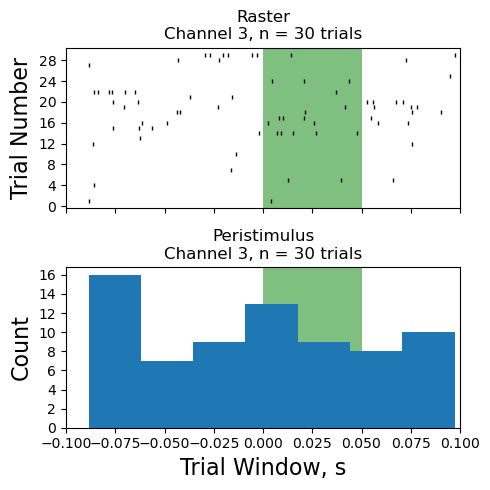

In [7]:
REF_EPOC = 'Freq'
Lev_EPOC = 'Levl'
SNIP_STORE = 'Snip'
SORTID = 'TankSort'
CHANNEL = 3
SORTCODE = 0 # set to 0 to use all sorts
TRANGE = [-0.1, 0.2]
BLOCK_PATH = file_ls[1]

data = tdt.read_block(BLOCK_PATH, evtype=['epocs', 'snips', 'scalars'],
sortname=SORTID, channel=CHANNEL, nodata=1)
data = tdt.epoc_filter(data, REF_EPOC, values=[khz], t=TRANGE)
data = tdt.epoc_filter(data, Lev_EPOC, values=[0], t=TRANGE)

raster_data = tdt.epoc_filter(data, REF_EPOC,values=[khz], t=TRANGE)


hist_data = tdt.epoc_filter(data, REF_EPOC,values=[khz], t=TRANGE, tref=1)



ts = raster_data.snips[SNIP_STORE].ts
if SORTCODE != 0:
    
    i = np.where(raster_data.snips[SNIP_STORE].sortcode == SORTCODE)[0]
    ts = ts[i]
if len(ts) == 0:
    raise Exception('no matching timestamps found')
num_trials = raster_data.time_ranges.shape[1]

fig, (ax2,ax1) = plt.subplots(2, 1, sharex=True, figsize=(5, 5))

all_ts = [[] for x in range(num_trials)]
all_y = [[] for x in range(num_trials)]
for trial in range(num_trials):
    trial_on = raster_data.time_ranges[0, trial]
    trial_off = raster_data.time_ranges[1, trial]
    ind1 = ts >= trial_on
    ind2 = ts < trial_off
    trial_ts = ts[ind1 & ind2]
    all_ts[trial] = trial_ts - trial_on + TRANGE[0]
    all_y[trial] = (trial+1) * np.ones(len(trial_ts))

all_x = np.concatenate(all_ts)
all_y = np.concatenate(all_y)

# Make the raster plot.
ax2.plot(all_x, all_y, 'k.', markersize=3, marker = '|')
ax2.axis('tight')
ax2.set_xlim(left=TRANGE[0], right=TRANGE[0]+TRANGE[1])

ax2.set_ylabel('Trial Number',fontsize=16)
ax2.set_title('Raster\nChannel {0}, n = {1} trials'.format(CHANNEL, num_trials))
ax2.axvspan(0, 0.05, facecolor='g',alpha=.5,zorder=-100)


ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

hist_ts = hist_data.snips[SNIP_STORE].ts
nbins = np.int64(np.floor(len(hist_ts)/10.))
hist_n = ax1.hist(hist_ts, nbins)[0]
ax1.axis('tight')
ax1.set_xlim(left=TRANGE[0], right=TRANGE[0]+TRANGE[1])
ax1.set_ylabel('Count',fontsize=16)
ax1.set_title('Peristimulus\nChannel {0}, n = {1} trials'.format(CHANNEL,
num_trials))
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
# Draw a vertical line at t=0.
#ax1.plot([0, 0], [0, np.max(hist_n)], 'r-', linewidth=3)
ax1.axvspan(0, 0.05, facecolor='g',alpha=.5,zorder=-100)

ax1.set_xlabel('Trial Window, s',fontsize=16)


plt.tight_layout()


# The main calculations to be iterated

In [182]:
# determine if evoked firing is significant 
# unpair ttest to compare 100 ms pre stim and post stim
# make a dataframe of < 0 and one of >0 since we have already taken ts of -.1 to +.1 sec
# count the number of negative and positive values for each row (trial)
# store each in their own column
# ttest on those columns


ts_df = pd.DataFrame(all_ts) # convert to dataframe for my personal enjoyment
neg_counts = [] # placeholder
pos_counts = [] # placehodler
#ts_df.columns = ['timestamps']
for index, row in ts_df.iterrows(): # loop over each row
        neg_cells = (row < 0) # get indexes of negative values in the row
        neg_counts.append(len(row[neg_cells])) # add the count of the values to a list
        pos_cells = (row >= 0) # get indexes of poitive values in the row
        pos_counts.append(len(row[pos_cells])) # add the count of the values to a list

ts_df['Poststim'] = pos_counts# append to a positive column
ts_df['Prestim'] = neg_counts# append to a negative

# convert to firing rate
# 100 ms = 0.1 sec
ts_df['Post_fr'] = ts_df['Poststim'].div(.1) # divide the count over the time range to get spk/s
ts_df['Pre_fr'] = ts_df['Prestim'].div(.1) # divide the count over the time range to get spk/s
from scipy.stats import ttest_ind # import unpaired t-test

#pre_ttest = ts_df[ts_df['Stim_rel']=='Pre'] 
#post_ttest = ts_df[ts_df['Stim_rel']=='Post']

# do unpaired ttest
ttest_result = ttest_ind(ts_df['Pre_fr'], ts_df['Post_fr']) # give stat and p-value (we want p-value < 0.01 ideally)
ttest_result

if ttest_result[1] < 0.01:
    print('Significant: 1')


Significant: 1


In [180]:
ttest_result[1]

4.071930447310062e-10

In [157]:
change = ts_df['Post_fr'] - ts_df['Pre_fr']
# take average cahnge value


0      0.0
1     10.0
2      0.0
3    -10.0
4     10.0
5      0.0
6      0.0
7      0.0
8      0.0
9      0.0
10   -20.0
11     0.0
12     0.0
13     0.0
14    20.0
15     0.0
16   -40.0
17   -50.0
18   -10.0
19   -10.0
20     0.0
21     0.0
22     0.0
23    10.0
24    10.0
25     0.0
26    30.0
27    20.0
28   -10.0
29    30.0
dtype: float64

In [71]:
# evoked = > spon fr by 4 standard deviations
# paired ttest2 between -.1 fr and 0-20 ms fr should work 
# dB x khz matrix of significance 

# or could just get change in fr from avg spon (-.1 to 0) and avg from 0-20ms
# z-score them and plot a heat map. Take all cells over a certain z-score value then take the width of those cells one row
# above the threshold row

array([-5.2469760e-02, -3.2071680e-02, -9.2897280e-02, -8.2165760e-02,
       -2.8467200e-02,  2.2077440e-02,  2.1053440e-02,  1.3598720e-02,
        2.2200320e-02,  2.9736960e-02,  1.3844480e-02,  2.6460160e-02,
        3.4078720e-02,  1.0870784e-01,  1.1546624e-01,  3.3136640e-02,
       -5.4435840e-02, -4.5178880e-02,  5.9801600e-03,  1.9947520e-02,
        2.2528000e-02,  2.5067520e-02,  3.1744000e-02,  4.9807360e-02,
        1.1702272e-01,  4.3048960e-02,  5.8408960e-02,  1.6736256e-01,
       -9.3675520e-02, -6.6969600e-02,  1.2820480e-02,  1.1292672e-01,
        1.9427328e-01, -2.3347200e-03,  1.6424960e-02, -9.0439680e-02,
       -8.7285760e-02, -7.8561280e-02, -7.0451200e-02, -7.9667200e-02,
       -3.8666240e-02, -3.6208640e-02,  1.2288000e-02,  2.4985600e-02,
        3.2563200e-02,  3.5512320e-02,  4.5547520e-02,  1.2550144e-01,
        1.3058048e-01,  1.4217216e-01,  7.4874880e-02,  7.7946880e-02,
       -5.8368000e-02, -6.0497920e-02, -5.4312960e-02, -3.9976960e-02,
      

In [7]:
data = tdt.read_block('F:\Fmr1 SD Tanks\WT\BA190305A\Block-2',channel = 3)

read from t=0s to t=1716.06s
Using 24414.0625 Hz as SEV sampling rate for SKW1
Using 24414.0625 Hz as SEV sampling rate for SKW2


In [8]:
data = tdt.epoc_filter(data, 'Levl', t=[-0.025, 0.03])

In [9]:
print(data)

epocs	[struct]
snips	[struct]
streams	[struct]
scalars	[struct]
info	[struct]
time_ranges:	array([[2.75154880e-01, 5.75145920e-01, 8.75136960e-01, ...,
        1.71502394e+03, 1.71532393e+03, 1.71562392e+03],
       [3.05154880e-01, 6.05145920e-01, 9.05136960e-01, ...,
        1.71505394e+03, 1.71535393e+03, 1.71565392e+03]])
time_ref:	[-0.025, 0.03]
filter:	'TIME:Levl [-0.02:0.03];'


In [16]:
time_SKW1 = np.linspace(1, len(data.streams.Wave.data),
len(data.streams.Wave.data)) / data.streams.Wave.fs

Text(0.5, 1.0, 'Basic Data Plotting: Ch 1\nRaw Waveform')

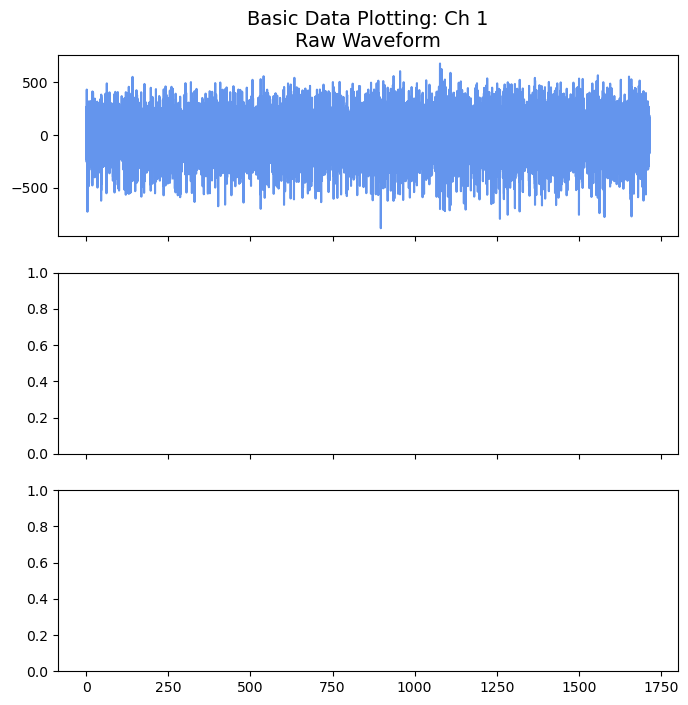

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(8, 8),
sharex=True)
ax1.plot(time_SKW1, data.streams.Wave.data*1e6, color='cornflowerblue')
ax1.set_title('Basic Data Plotting: Ch 1\nRaw Waveform', fontsize=14)


In [43]:
REF_EPOC = 'Freq'
SNIP_STORE = 'Snip'
SORTID = 'TankSort'
CHANNEL = 3
SORTCODE = 0 # set to 0 to use all sorts
TRANGE = [-0.1, 0.3]
BLOCK_PATH = 'F:\Fmr1 SD Tanks\WT\BA190305A\Block-2'

In [44]:
data = tdt.read_block(BLOCK_PATH, evtype=['epocs', 'snips', 'scalars'],
sortname=SORTID, channel=CHANNEL, nodata=1)

read from t=0s to t=1716.06s


In [45]:
raster_data = tdt.epoc_filter(data, REF_EPOC,values=[8000], t=TRANGE)

In [46]:
hist_data = tdt.epoc_filter(data, REF_EPOC,values=[8000], t=TRANGE, tref=1)

In [47]:
ts = raster_data.snips[SNIP_STORE].ts
if SORTCODE != 0:
    
    i = np.where(raster_data.snips[SNIP_STORE].sortcode == SORTCODE)[0]
    ts = ts[i]
if len(ts) == 0:
    raise Exception('no matching timestamps found')
num_trials = raster_data.time_ranges.shape[1]

In [60]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5, 8))
hist_ts = hist_data.snips[SNIP_STORE].ts
nbins = np.int64(np.floor(len(hist_ts)/10.))
hist_n = ax1.hist(hist_ts, nbins)[0]
ax1.axis('tight')
ax1.set_xlim(left=TRANGE[0], right=TRANGE[0]+TRANGE[1])
ax1.set_ylabel('Count',fontsize=16)
ax1.set_title('Peristimulus\nChannel {0}, n = {1} trials'.format(CHANNEL,
num_trials))
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
# Draw a vertical line at t=0.
ax1.plot([0, 0], [0, np.max(hist_n)], 'r-', linewidth=3)





SyntaxError: invalid syntax (2481954525.py, line 3)

In [57]:
REF_EPOC = 'Freq'
STREAM_STORE = 'SKW2'
SORTID = 'TankSort'
CHANNEL = 3
SORTCODE = 0 # set to 0 to use all sorts
TRANGE = [-0.1, 0.3]
BLOCK_PATH = 'F:\Fmr1 SD Tanks\WT\BA190305A\Block-2'

In [58]:
data = tdt.read_block(BLOCK_PATH, evtype=['epocs','scalars','streams'],
channel=CHANNEL)

read from t=0s to t=1716.06s
Using 24414.0625 Hz as SEV sampling rate for SKW1
Using 24414.0625 Hz as SEV sampling rate for SKW2


In [60]:
data = tdt.epoc_filter(data, REF_EPOC,values=[8000], t=TRANGE)

In [61]:
min_length = np.min([len(x) for x in data.streams[STREAM_STORE].filtered])
data.streams[STREAM_STORE].filtered = [x[:min_length] for x in
data.streams[STREAM_STORE].filtered]

In [62]:
all_signals = np.vstack(data.streams[STREAM_STORE].filtered)
mean_signal = np.mean(all_signals, axis=0)
std_signal = np.std(all_signals, axis=0)

In [63]:
ts = TRANGE[0] + np.arange(0, min_length) / data.streams[STREAM_STORE].fs

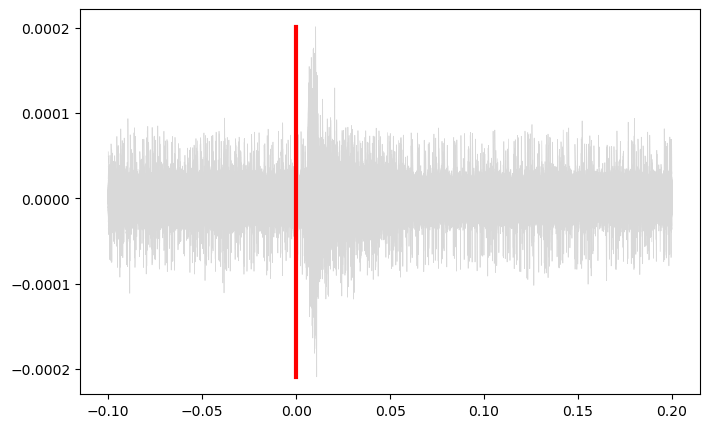

In [68]:
fig, ax1 = plt.subplots(1, 1, figsize=(8,5))
ax1.plot(ts, all_signals.T, color=(.85,.85,.85), linewidth=0.5)
ax1.plot([0, 0], [np.min(all_signals), np.max(all_signals)], color='r',
linewidth=3)


In [70]:
REF_EPOC = 'Freq'
STREAM_STORE = 'Wave'
SORTID = 'TankSort'
CHANNEL = 3
SORTCODE = 0 # set to 0 to use all sorts
TRANGE = [-0.1, 0.3]
BLOCK_PATH = 'F:\Fmr1 SD Tanks\WT\BA190305A\Block-2'

In [71]:
data = tdt.read_block(BLOCK_PATH, evtype=['epocs','scalars','streams'],
channel=CHANNEL)

read from t=0s to t=1716.06s
Using 24414.0625 Hz as SEV sampling rate for SKW1
Using 24414.0625 Hz as SEV sampling rate for SKW2


In [72]:
data = tdt.epoc_filter(data, REF_EPOC,values=[8000], t=TRANGE)

In [74]:
min_length = np.min([len(x) for x in data.streams[STREAM_STORE].filtered])
data.streams[STREAM_STORE].filtered = [x[:min_length] for x in
data.streams[STREAM_STORE].filtered]
all_signals = np.vstack(data.streams[STREAM_STORE].filtered)
mean_signal = np.mean(all_signals, axis=0)
std_signal = np.std(all_signals, axis=0)

In [75]:
ts = TRANGE[0] + np.arange(0, min_length) / data.streams[STREAM_STORE].fs

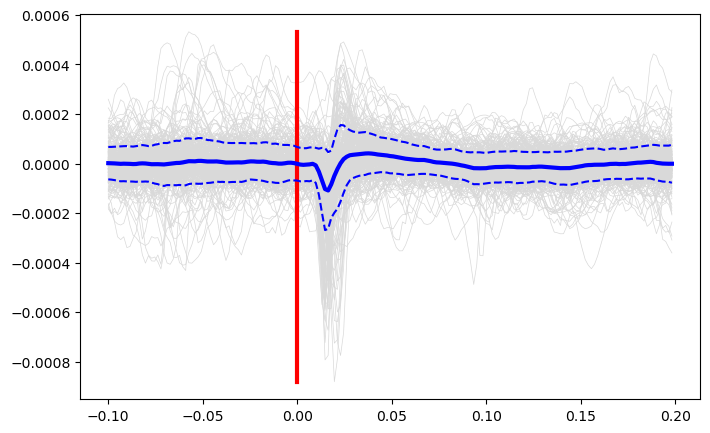

In [78]:
fig, ax1 = plt.subplots(1, 1, figsize=(8,5))
ax1.plot(ts, all_signals.T, color=(.85,.85,.85), linewidth=0.5)
ax1.plot([0, 0], [np.min(all_signals), np.max(all_signals)], color='r',
linewidth=3)
ax1.plot(ts, mean_signal, color='b', linewidth=3)

ax1.plot(ts, mean_signal + std_signal, 'b--', ts, mean_signal - std_signal,
'b--')

